Run the HardwareSetup script to get access to ```hardware_setup``` and ```alazar_DAC```

In [1]:
%run HardwareSetup.ipynb

import os
os.getpid()

11308

Start the atsaverage status window

In [2]:
import atsaverage.gui
status_window = atsaverage.gui.ThreadedStatusWindow(alazar_DAC.card)
status_window.start()

Load the example pulse

In [19]:
from qupulse.serialization import Serializer, FilesystemBackend
from qupulse.pulses import PointPT, TablePT

nested_loop_pulse = Serializer(FilesystemBackend('./serialized_pulses')).deserialize('complicated')

trig_pulse = TablePT({'A': [(0, 0)], 'marker': [(0, 1), ('trig_len', 1)]})

nested_loop_pulse = trig_pulse @ nested_loop_pulse

parameters=dict(N_T=10, N_T_rep=1, N_rep=3, T=192, T_start=2*192, T_step=160, trig_len=192)

assert nested_loop_pulse.measurement_names == {'M'}

alazar_DAC.register_mask_for_channel('M', 0)

In [20]:
operations = [atsaverage.operations.Downsample()]
operations[0].maskID = 'M'
operations[0].identifier = 'DSM'

alazar_DAC.register_operations('nested_loops', operations)

# store raw data for later inspection
alazar_DAC.config.rawDataMask = atsaverage.atsaverage.ChannelMask(1)

In [21]:
from qupulse.pulses.sequencing import Sequencer

seq = Sequencer()
seq.push(nested_loop_pulse, 
         parameters=parameters, channel_mapping=dict(A='TABOR_A', marker='TABOR_A_MARKER'))
g = seq.build()

Multiply all voltages of ```TABOR_A``` with 0.5

In [28]:
hardware_setup.rm_channel('TABOR_A')
hardware_setup.set_channel('TABOR_A', PlaybackChannel(tchannelpair_AB, 0, voltage_transformation=lambda x: 0.5*x))
hardware_setup.register_program('nested_loops', g, update=True)

In [31]:
hardware_setup.arm_program('nested_loops')

In [34]:
tchannelpair_AB.run_current_program()

In [25]:
results = alazar_DAC.card.extractNextScanline()

In [26]:
raw = results.rawData

<IPython.core.display.Javascript object>


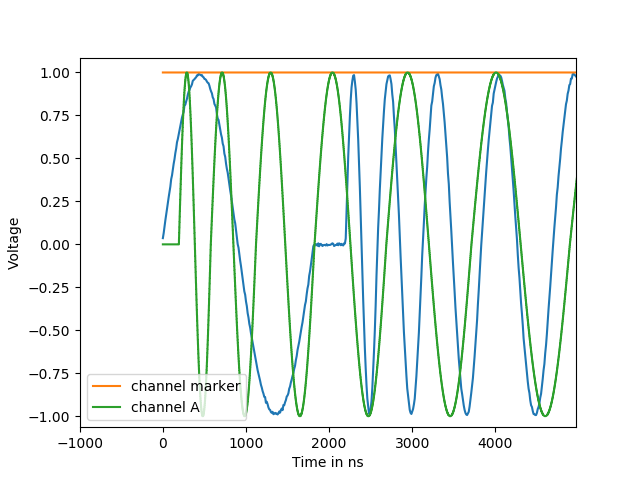

In [27]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
#plt.plot(raw)
meas_rate = 10
fig = plt.figure()
ax = fig.add_subplot(111)
to_plot = ((raw - np.mean(raw)) * (2. / (np.max(raw) - np.min(raw))))
ax.plot(np.arange(len(to_plot)) * meas_rate,to_plot)

import qupulse.pulses.plotting as qcplot

fig = qcplot.plot(nested_loop_pulse, parameters, sample_rate=1, axes=ax)

1000000000

In [16]:
alazar_DAC.config.triggerConfiguration.triggerLevel1 = 129
alazar_DAC.update_settings = True

In [ ]:
type(fig.axes[0])


In [12]:
alazar_DAC.config.totalRecordSize = 4*1024
alazar_DAC.update_settings = True